In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import log_loss

%matplotlib inline
all_train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [221]:
all_train = all_train.reindex(np.random.permutation(all_train.index))

split = all_train.shape[0] // 20
dev = all_train[:split]
train = all_train[split:]


Logistc Regression Log Loss: 1.20
Logistc Regression Accuracy: 0.418
Naive Bayes Log Loss: 1.22
Naive Bayes Accuracy: 0.424


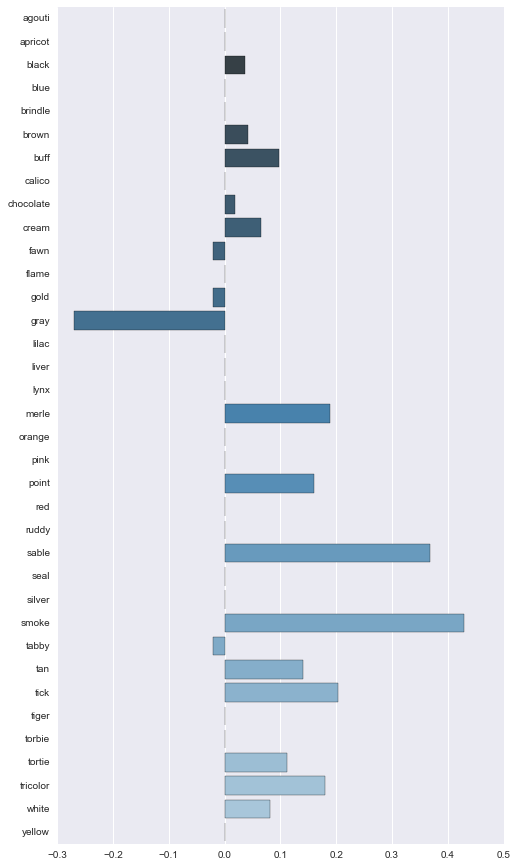

In [222]:
cv = CountVectorizer()
train_corpus = cv.fit_transform(train.Color)
dev_corpus = cv.transform(dev.Color)

clf = LogisticRegression(penalty='l1', C=0.1)
clf.fit(train_corpus, train.OutcomeType)
preds = clf.predict_proba(dev_corpus)
print 'Logistc Regression Log Loss: {:.3f}'.format(log_loss(dev.OutcomeType, preds))
print 'Logistc Regression Accuracy: {:.3f}'.format(clf.score(dev_corpus, dev.OutcomeType))

plt.figure(figsize=(8,15))
sns.barplot(x=clf.coef_[0], y=cv.get_feature_names(), palette='Blues_d', orient = 'h')

clf = BernoulliNB()
clf.fit(train_corpus, train.OutcomeType)
preds = clf.predict_proba(dev_corpus)
print 'Naive Bayes Log Loss: {:.3f}'.format(log_loss(dev.OutcomeType, preds))
print 'Naive Bayes Accuracy: {:.3f}'.format(clf.score(dev_corpus, dev.OutcomeType))

plt.show()

Logistc Regression Log Loss: 1.205
Logistc Regression Accuracy: 0.412
Naive Bayes Log Loss: 1.21
Naive Bayes Accuracy: 0.413


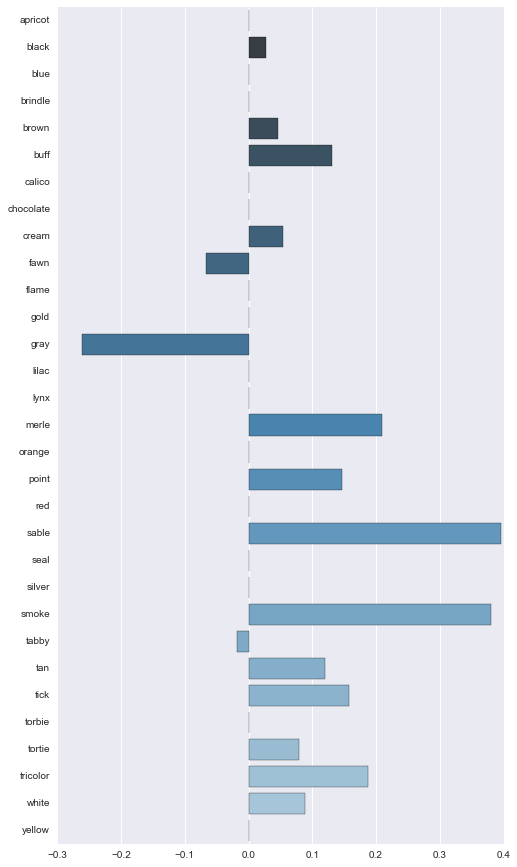

In [219]:
cv = CountVectorizer(min_df=30)
train_corpus = cv.fit_transform(train.Color)
dev_corpus = cv.transform(dev.Color)

clf = LogisticRegression(penalty='l1', C=0.1)
clf.fit(train_corpus, train.OutcomeType)
preds = clf.predict_proba(dev_corpus)
print 'Logistc Regression Log Loss: {:.3f}'.format(log_loss(dev.OutcomeType, preds))
print 'Logistc Regression Accuracy: {:.3f}'.format(clf.score(dev_corpus, dev.OutcomeType))

plt.figure(figsize=(8,15))
sns.barplot(x=clf.coef_[0], y=cv.get_feature_names(), palette='Blues_d', orient = 'h')

clf = BernoulliNB()
clf.fit(train_corpus, train.OutcomeType)
preds = clf.predict_proba(dev_corpus)
print 'Naive Bayes Log Loss: {:.2f}'.format(log_loss(dev.OutcomeType, preds))
print 'Naive Bayes Accuracy: {:.3f}'.format(clf.score(dev_corpus, dev.OutcomeType))

plt.show()

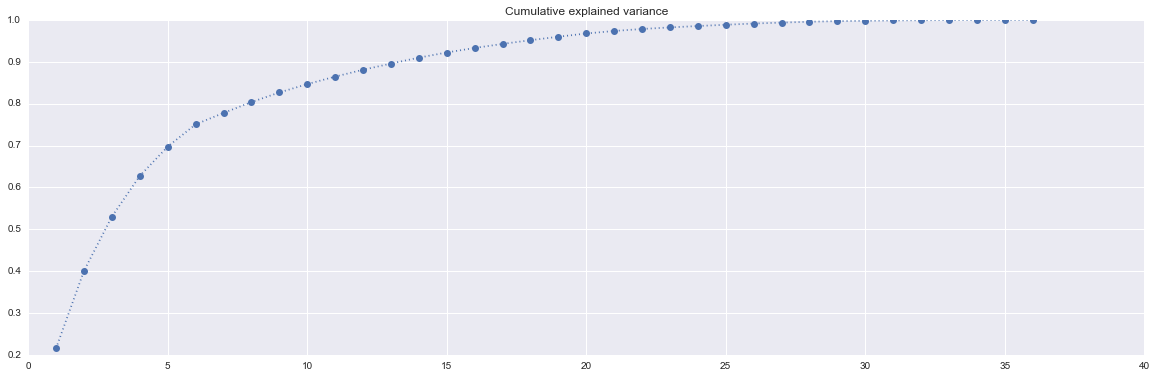

In [223]:
pca_mod = PCA()
pca_mod.fit(train_corpus.toarray())

plt.figure(figsize=(20,6))
plt.plot(range(1,pca_mod.n_components_+1), np.cumsum(pca_mod.explained_variance_ratio_), marker='o', linestyle=':')
plt.title('Cumulative explained variance')

plt.show()

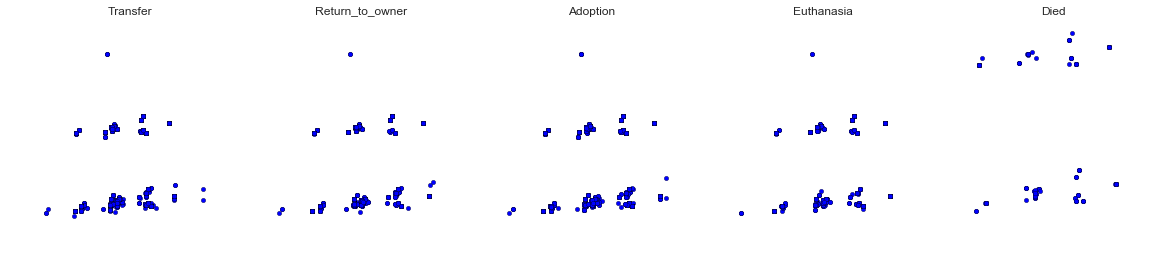

In [224]:
pca_mod = PCA(n_components=2)

train_reduced = pca_mod.fit_transform(train_corpus.toarray())
plt.figure(figsize=(20,4))


for i, outcome in enumerate(pd.unique(train.OutcomeType)):
    index = np.where(train.OutcomeType == outcome)
    d = train_reduced[index]
    
    plt.subplot(1, 5, i+1)
    plt.scatter(d[:,0], d[:,1])
    plt.title(outcome)
    plt.axis('off')

In [225]:
for ncomps in range(1,31):
    pca_mod = PCA(n_components=ncomps)

    train_reduced = pca_mod.fit_transform(train_corpus.toarray())
    dev_reduced = pca_mod.transform(dev_corpus.toarray())

    clf = LogisticRegression(penalty='l1', C=0.1)
    clf.fit(train_reduced, train.OutcomeType)
    preds = clf.predict_proba(dev_reduced)
    print 'Logistic Regression Log Loss with {:} PCA components: {:.4f}'.format(ncomps, log_loss(dev.OutcomeType, preds))

Logistic Regression Log Loss with 1 PCA components: 1.2380
Logistic Regression Log Loss with 2 PCA components: 1.2344
Logistic Regression Log Loss with 3 PCA components: 1.2343
Logistic Regression Log Loss with 4 PCA components: 1.2103
Logistic Regression Log Loss with 5 PCA components: 1.2104
Logistic Regression Log Loss with 6 PCA components: 1.2103
Logistic Regression Log Loss with 7 PCA components: 1.2097
Logistic Regression Log Loss with 8 PCA components: 1.2101
Logistic Regression Log Loss with 9 PCA components: 1.2053
Logistic Regression Log Loss with 10 PCA components: 1.2059
Logistic Regression Log Loss with 11 PCA components: 1.2060
Logistic Regression Log Loss with 12 PCA components: 1.2060
Logistic Regression Log Loss with 13 PCA components: 1.2009
Logistic Regression Log Loss with 14 PCA components: 1.2009
Logistic Regression Log Loss with 15 PCA components: 1.2019
Logistic Regression Log Loss with 16 PCA components: 1.2012
Logistic Regression Log Loss with 17 PCA componen